# Econometrics 1 - TD 5

## 14/11/2024

In [3]:
######### Econometrics 1 - TD 5


# Install packages
if(!require(haven)) install.packages("haven")  
if(!require(glmnet)) install.packages("glmnet")
if(!require(plotmo)) install.packages("plotmo")  
if(!require(dplyr)) install.packages("dplyr")
if(!require(knitr)) install.packages("knitr")
if(!require(leaps)) install.packages("leaps")

# Load necessary libraries
library(haven)     # For reading Stata files
library(glmnet)    # For Lasso and Ridge regression
library(plotmo)    # For plots using Lasso and Ridge
library(dplyr)     # For data manipulation
library(knitr)     # For data manipulation
library(leaps)     # For data manipulation

# Set path
#setwd("")

# Load the data
data <- read_dta("prostate.dta")

1. Regress lpsa on the whole set of covariates using the training sample. Compute the
prediction error on the training sample and on the validation one. Compare these results
with the ones you get from the model that only includes a constant as vector of covariates.

In [4]:
### Question 1 - Prediction error using the full set of covariates

train_data <- data %>% filter(train == "T")
test_data <- data %>% filter(train == "F")
variables <- c("lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45")

# Linear regression on training data
full_model <- lm(lpsa ~ lcavol + lweight + age + lbph + svi + lcp + gleason + pgg45, data = train_data)
train_data$lpsa_hat <- predict(full_model, newdata = train_data)
test_data$lpsa_hat <- predict(full_model, newdata = test_data)

# Calculate prediction error on training set
train_data$errsq_full <- (train_data$lpsa - train_data$lpsa_hat)^2
train_error_full <- mean(train_data$errsq_full)

# Calculate prediction error on validation set
test_data$errsq_full <- (test_data$lpsa - test_data$lpsa_hat)^2
test_error_full <- mean(test_data$errsq_full)

# Prediction error using only a constant for covariates
constant_model <- lm(lpsa ~ 1, data = train_data)
train_data$lpsa_hat <- predict(constant_model, newdata = train_data)
test_data$lpsa_hat <- predict(constant_model, newdata = test_data)

# Calculate prediction error on training set with constant model
train_data$errsq_constant <- (train_data$lpsa - train_data$lpsa_hat)^2
train_error_constant <- mean(train_data$errsq_constant)

# Calculate prediction error on validation set with constant model
test_data$errsq_constant <- (test_data$lpsa - test_data$lpsa_hat)^2
test_error_constant <- mean(test_data$errsq_constant)

train_error_full
train_error_constant

test_error_full
test_error_constant

[1] 0.4391998

[1] 1.437037

[1] 0.521274

[1] 1.056733

3. Install the leaps package in R by executing install.packages("leaps"). You can
ﬁnd more information about the package by using ?leaps.

    (a) Use leaps to determine the optimal sub-models of all sizes.

    (b) Identify the best model based on the error in the validation sample.

In [5]:
#### Question 3 - Determine the best sub-models for k = 1 to k = 8

# Subset selection using `leaps`
leaps_result <- regsubsets(as.formula(paste("lpsa ~", paste(variables, collapse = " + "))),
                           data = train_data, nvmax = length(variables), method = "exhaustive")

# Extract summary of the subset selection
leaps_summary <- summary(leaps_result)

# Get the variables of the best model for each subset size
best_model_vars <- list()
for (i in 1:(leaps_result$np - 1)) {
  best_model_vars[[i]] <- names(coef(leaps_result, i))[-1]  # Exclude intercept
}

# Print the best model for each subset size based on BIC
for (i in 1:length(best_model_vars)) {
  cat("Best model with", i, "variables:", best_model_vars[[i]], "\n")
}

# Determine the best model based on the validation sample

errsq_sub_models <- list()

for (i in 1:(leaps_result$np - 1)) {
  # Get the formula for the current model
  formula <- as.formula(paste("lpsa ~", paste(best_model_vars[[i]], collapse = " + ")))
  
  # Fit the model with the selected variables
  model <- lm(formula, data = train_data)
  
  # Predict 
  test_data$lpsa_hat <- predict(model, newdata = test_data)
  
  # Calculate prediction error on training set with constant model
  test_data$errsq <- (test_data$lpsa - test_data$lpsa_hat)^2
  errsq_sub_models[[i]] <- mean(test_data$errsq)
}

# Print the MSE for each subset size
for (i in 1:length(best_model_vars)) {
  cat("MSE of the validation sample using the best model with", i, "variables:", errsq_sub_models[[i]], "\n")
}


Best model with 1 variables: lcavol 
Best model with 2 variables: lcavol lweight 
Best model with 3 variables: lcavol lweight svi 
Best model with 4 variables: lcavol lweight lbph svi 
Best model with 5 variables: lcavol lweight lbph svi pgg45 
Best model with 6 variables: lcavol lweight lbph svi lcp pgg45 
Best model with 7 variables: lcavol lweight age lbph svi lcp pgg45 
Best model with 8 variables: lcavol lweight age lbph svi lcp gleason pgg45 
MSE of the validation sample using the best model with 1 variables: 0.4797387 
MSE of the validation sample using the best model with 2 variables: 0.4924823 
MSE of the validation sample using the best model with 3 variables: 0.4005308 
MSE of the validation sample using the best model with 4 variables: 0.4563321 
MSE of the validation sample using the best model with 5 variables: 0.4859242 
MSE of the validation sample using the best model with 6 variables: 0.5485933 
MSE of the validation sample using the best model with 7 variables: 0.516

4. What is the optimal model according to AIC? According to BIC? Does the diﬀerence
between the two make sense?

In [6]:
#### Question 4 - optimal models from AIC and BIC

## Note : for AIC and BIC, we use the training sample

# Identify the best model for each subset size based on AIC

aic_values <- numeric(leaps_result$np - 1)

# Calculate AIC for each subset model
for (i in 1:length(aic_values)) {
  # Get the formula for the current model
  selected_vars <- names(coef(leaps_result, i))[-1]  # Exclude intercept
  formula <- as.formula(paste("lpsa ~", paste(selected_vars, collapse = " + ")))
  
  # Fit the model with the selected variables
  model <- lm(formula, data = train_data)
  
  # Calculate AIC and store it
  aic_values[i] <- AIC(model)
}

# Identify the best model for each subset size based on BIC
baseline_bic <- BIC(lm(lpsa ~ 1, data = train_data)) - log(dim(train_data)[1])
bic_values <- baseline_bic + leaps_summary$bic

# Print the AIC values for each subset size
for (i in 1:length(aic_values)) {
  cat("Subset Size:", i, "| AIC:", aic_values[i], "| BIC:", bic_values[i], "| Variables:", names(coef(leaps_result, i))[-1], "\n")
}


Subset Size: 1 | AIC: 168.7642 | BIC: 175.3782 | Variables: lcavol 
Subset Size: 2 | AIC: 158.521 | BIC: 167.3397 | Variables: lcavol lweight 
Subset Size: 3 | AIC: 156.4548 | BIC: 167.4783 | Variables: lcavol lweight svi 
Subset Size: 4 | AIC: 154.3127 | BIC: 167.5408 | Variables: lcavol lweight lbph svi 
Subset Size: 5 | AIC: 154.7729 | BIC: 170.2058 | Variables: lcavol lweight lbph svi pgg45 
Subset Size: 6 | AIC: 153.4984 | BIC: 171.1359 | Variables: lcavol lweight lbph svi lcp pgg45 
Subset Size: 7 | AIC: 153.035 | BIC: 172.8772 | Variables: lcavol lweight age lbph svi lcp pgg45 
Subset Size: 8 | AIC: 155.0101 | BIC: 177.057 | Variables: lcavol lweight age lbph svi lcp gleason pgg45 


5. We want to perform Lasso or ridge regression. Why is it desirable to standardize the
variables beforehand? Perform this standardization.

In [7]:
#### Question 5 - Standardization ####

scale(data[2:8])

data <- data %>%
  mutate(across(all_of(variables), ~ scale(.)[, 1]))

lcavol,lweight,age,lbph,svi,lcp,gleason
-1.63735562,-2.00621184,-1.86242597,-1.02470580,-0.5229409,-0.8631712,-1.0421573
-1.98898045,-0.72200855,-0.78789619,-1.02470580,-0.5229409,-0.8631712,-1.0421573
-1.57881888,-2.18878427,1.36116337,-1.02470580,-0.5229409,-0.8631712,0.3426271
-2.16691709,-0.80799393,-0.78789619,-1.02470580,-0.5229409,-0.8631712,-1.0421573
-0.50787448,-0.45883394,-0.25063130,-1.02470580,-0.5229409,-0.8631712,-1.0421573
-2.03612847,-0.93395456,-1.86242597,-1.02470580,-0.5229409,-0.8631712,-1.0421573
-0.51996655,-0.36279339,0.01800114,0.35485778,-0.5229409,-0.8631712,-1.0421573
-0.55731252,-0.20875642,-0.78789619,0.99014688,-0.5229409,-0.8631712,-1.0421573
-1.80425375,-0.20875642,-2.26537464,-1.02470580,-0.5229409,-0.8631712,-1.0421573
-0.95608540,-0.89726555,-0.11631508,-1.02470580,-0.5229409,-0.8631712,-1.0421573


6. Install the glmnet package in R by executing the following command: install.packages.
Then use this package to estimate a LASSO model regressing Y on X, and produce a graph
displaying the estimated LASSO coeﬃcients as a function of ln(λ), where λ is the penalty
parameter.

    (a) Perform a LASSO regression of Y on X using glmnet.

    (b) Plot a graph showing the evolution of the estimated coeﬃcients as a function of ln(λ).
    
    (c) Comment on the results

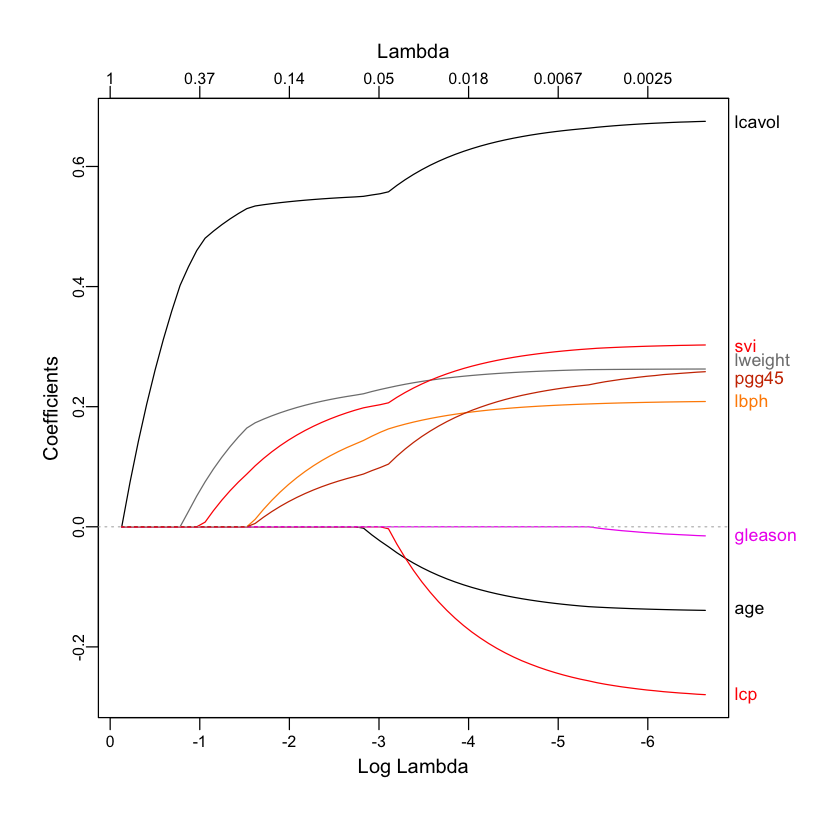

In [8]:

#### Question 6 - Lasso regression and plot of coefficients ####

train_data <- data %>% filter(train == "T")
test_data <- data %>% filter(train == "F")

# Lasso regression on training data
x_train <- as.matrix(train_data[, variables])
y_train <- train_data$lpsa
lasso_model <- glmnet(x_train, y_train, alpha = 1)

# Plot the coefficient paths
plot_glmnet(lasso_model, label = TRUE)

7. What is the optimal penalty parameter λ obtained through cross-validation using the
glmnet package with the cv.glmnet option in R? Comment on the diﬀerences be-
tween the estimated LASSO coeﬃcients and those obtained from an OLS regression (post-
LASSO) using only the variables selected by the LASSO model.

    (a) Use cross-validation to determine the optimal value of λ using cv.glmnet.
    
    (b) Comment on the diﬀerences between the "Lasso" and "Post-OLS" columns.

9 x 1 sparse Matrix of class "dgCMatrix"
                    s0
(Intercept)  2.4669874
lcavol       0.6562997
lweight      0.2595844
age         -0.1259456
lbph         0.2015303
svi          0.2898669
lcp         -0.2388937
gleason      .        
pgg45        0.2270825



Call:
lm(formula = as.formula(paste("lpsa ~", paste(selected_features, 
    collapse = " + "))), data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.65425 -0.34471 -0.05615  0.44380  1.48952 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.46687    0.08760  28.161  < 2e-16 ***
lcavol       0.67645    0.12384   5.462 9.88e-07 ***
lweight      0.26528    0.09363   2.833   0.0063 ** 
age         -0.14503    0.09757  -1.486   0.1425    
lbph         0.20953    0.10128   2.069   0.0430 *  
svi          0.30709    0.12190   2.519   0.0145 *  
lcp         -0.28722    0.15300  -1.877   0.0654 .  
pgg45        0.25228    0.11562   2.182   0.0331 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7064 on 59 degrees of freedom
Multiple R-squared:  0.6943,	Adjusted R-squared:  0.658 
F-statistic: 19.14 on 7 and 59 DF,  p-value: 4.496e-13


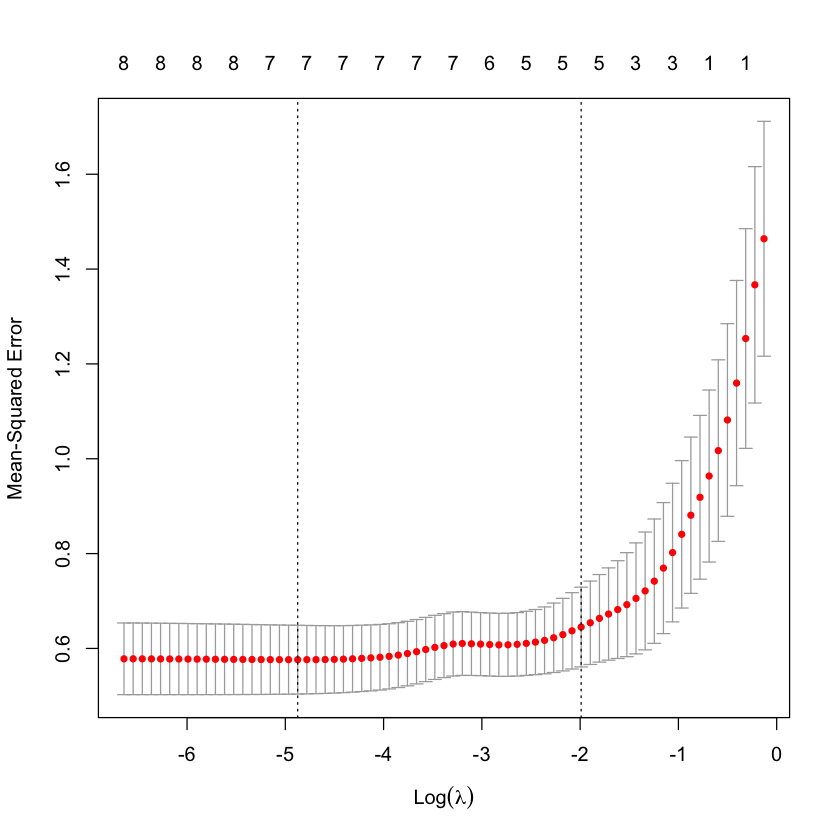

In [9]:
#### Question 7 - Cross-validation for Lasso and post-lasso regression ####

# Cross-validation to determine best lambda
set.seed(1)
cv_lasso <- cv.glmnet(x_train, y_train, alpha = 1)

# Plot cross-validation error
plot(cv_lasso)

# Best lambda for Lasso
set.seed(1)
lambda_opt <- cv_lasso$lambda.min

### Lasso
lasso_opt <- glmnet(x_train, y_train, alpha = 1, lambda = lambda_opt)
lasso_coefficients <- coef(lasso_opt)
print(lasso_coefficients)

### Post Lasso
selected_features <- rownames(lasso_coefficients)[lasso_coefficients[, 1] != 0][-1]  # Exclude intercept

# Fit OLS model with selected variables from Lasso
post_lasso_model <- lm(as.formula(paste("lpsa ~", paste(selected_features, collapse = " + "))), data = train_data)

# Summary of the post-LASSO model
summary(post_lasso_model)

8. What prediction error on the validation sample does this λ correspond to? Does it minimize
the prediction error on this sample, and why?

In [11]:
#### Question 8 - error from post-Lasso regression ####

# Prediction error with Post-Lasso on test set
test_data$lpsa_hat <- predict(post_lasso_model, newdata = test_data)
test_data$errsq_postlasso <- (test_data$lpsa - test_data$lpsa_hat)^2
post_lasso_error <- mean(test_data$errsq_postlasso, na.rm = TRUE)

post_lasso_error

[1] 0.5165135

9. Perform ridge regression by choosing the penalty parameter through cross-validation. Com-
pare the results to those of the Lasso from question 8, and the OLS of the full model.
3


In [13]:

# Cross-validation for Ridge
cv_ridge <- cv.glmnet(x_train, y_train, alpha = 0)

# Best lambda for Ridge
ridge_lambda_opt <- cv_ridge$lambda.min

# Ridge model with optimal lambda
ridge_model <- glmnet(x_train, y_train, alpha = 0, lambda = ridge_lambda_opt)

# Post-Ridge prediction on test set
test_data$lpsa_hat_ridge <- predict(ridge_model, newx = as.matrix(test_data[, variables]), s = ridge_lambda_opt)
test_data$errsq_ridge <- (test_data$lpsa - test_data$lpsa_hat_ridge)^2
ridge_error <- mean(test_data$errsq_ridge, na.rm = TRUE)


### Print all results

mse_results <- tibble(
  Model = c("Full Model", 
            "Constant Model", 
            "Best Model", 
            "AIC", 
            "BIC", 
            "Post-Lasso", 
            "Ridge"),
  MSE = c(test_error_full, 
          test_error_constant, 
          errsq_sub_models[3], 
          errsq_sub_models[8], 
          errsq_sub_models[2], 
          post_lasso_error, 
          ridge_error)
)

# Create and print a pretty table using knitr::kable

mse_table <- mse_results %>%
  kable(caption = "Mean Squared Error (MSE) for Different Models") 

mse_table





Table: Mean Squared Error (MSE) for Different Models

|Model          |MSE       |
|:--------------|:---------|
|Full Model     |0.521274  |
|Constant Model |1.056733  |
|Best Model     |0.4005308 |
|AIC            |0.521274  |
|BIC            |0.4924823 |
|Post-Lasso     |0.5165135 |
|Ridge          |0.4943855 |